In [1]:
import networkx as nx
import numpy as np
import random

#!pip install snscrape
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
import time
import pickle
import os
import matplotlib.pyplot as plt
from scipy.stats import poisson, levy_stable
from IPython.display import Image

# Task 1

## Random graph


In [118]:
#There will be Erdos-Renyi model, for graph with fixed number of links L between N nodes 
def Ernyi(N=20, L=20):
    if(L>N*(N-1)/2):
        raise ValueError ("To many edges!") # of course we cannot create matrix of 3 nodes with 4 edges
    G = nx.Graph()
    G.add_nodes_from([i+1 for i in range(N)]) #so we can start from 1
    iterator = 0
    while(iterator<L):
        #for_choice = [i for i in G.nodes]
        #i = random.choice(for_choice)
        #for_choice.remove(i)
        #j = random.choice(for_choice)
        [i,j] = random.sample(list(G.nodes), 2) #we take two nodes
        if not((i, j) in G.edges):
            G.add_edge(i, j) #we add
        else: #to maintain proper number of links
            iterator = iterator-1 
        iterator = iterator + 1
    #nx.draw_circular(G)
    return G

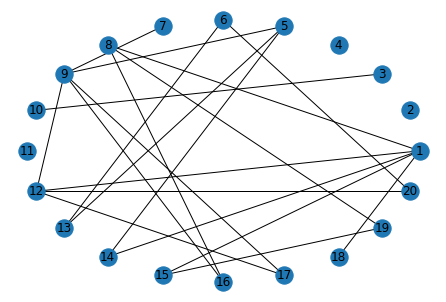

In [124]:
nx.draw_circular(Ernyi(20, 20), with_labels=True)

In [120]:
Ern_graph = Ernyi(20, 40)

40


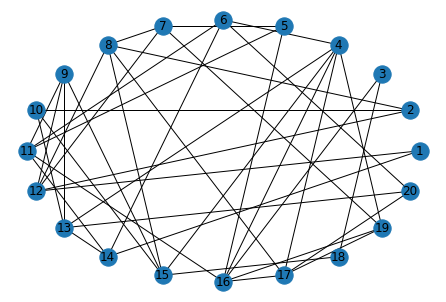

In [126]:
nx.draw_circular(Ern_graph, with_labels=True)
print(len(Ern_graph.edges))

# Watts-Strogatz model

In [104]:
#N is number of nodes, k is number of closest neighbours and p is probability that we change edge in single step
def Watatz(N=20, k=4, p=1):
    if(k%2==1):
        raise ValueError ("Need even number of closest neighbours!")
    
    #creates starting graph//do not move
    G = nx.Graph()
    #N = N-1 #because we start from 0
    G.add_nodes_from([i for i in range(N)])
    print(G.nodes)
    for i in G.nodes:
        for ki in range(int(k/2)):
            G.add_edges_from([((i+N-1-ki)%N,i), ((i+N+1+ki)%N,i)]) #calculations so N-1 is connected with 0
    
    #from here possible changes
    #changes link for each
    new_G = nx.Graph()
    iterator = 0

    for link in G.edges:
        #relinking
        if(random.random()<p): #if we succeed in relinking
            new_link = link #for now it is as before
            if(random.random()<0.5): #whether relink node 1 or 2 from edge
                #we do not want link that already was in network, not that we have in currently created one
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[0])
                    relink = random.choice(for_choice)
                    new_link = (new_link[0], relink)
                new_G.add_edge(new_link[0], new_link[1])
            else: #same procedure, but we change second end of edge
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[1])
                    relink = random.choice(for_choice)
                    new_link = (relink, new_link[1])
                new_G.add_edge(new_link[0], new_link[1])
        else: #we simply add link that existed in starting network
            new_G.add_edge(link[0], link[1])
        iterator = iterator+1
        
    new_G.add_nodes_from(list(G.nodes)) #in case some node got totally unconnected
    #nx.draw_circular(G)
    return new_G

In [110]:
G = Watatz(10, 4,0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


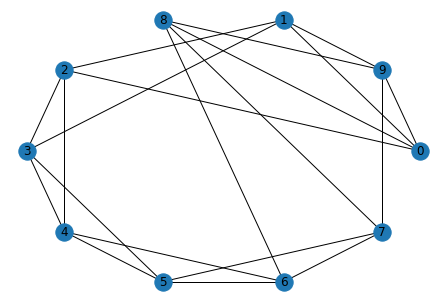

In [112]:
nx.draw_circular(G, with_labels=True) #looks a bit weird, but it only 0 mispositioned

In [83]:
G.nodes

NodeView((0, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

# Barabasi model

In [28]:
''' we start with m0 nodes and in each step we add node connected to m<m0 previous nodes until we reach N nodes
    after t steps we should have N=m0+t nodes and E=m0+mt edges
'''
def Barabasi(m0, m, t):
    '''creating, start from 1 to be similar with previous ones
        we want to start with m0 nodes, m0 edges and each link connected,
        so I just start with triangle, then add new linked nodes'''
    
    G = nx.Graph()
    G.add_edges_from([(1,2), (1,3), (2,3)])
    for i in range(3,m0+1): 
        G.add_edge(i, random.choice(list(G.nodes)))
        
    #now we add new nodes, choose m distinct edges coming from new node
    for tau in range(t):
        choice_list =  random.sample(list(G.nodes), m)
        for link in choice_list:
            G.add_edge(link, tau+m0+1)
      
    return G

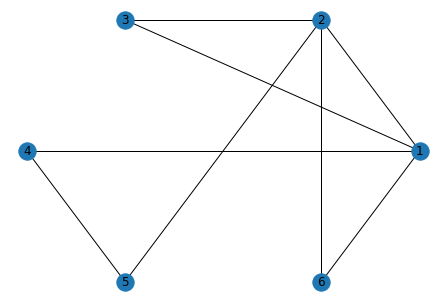

In [90]:
easy_to_check = Barabasi(m0=4, m=2, t=2)
nx.draw_circular(easy_to_check, with_labels=True) 

In [91]:
Bari_graph = Barabasi(m0=4, m=2, t=16)

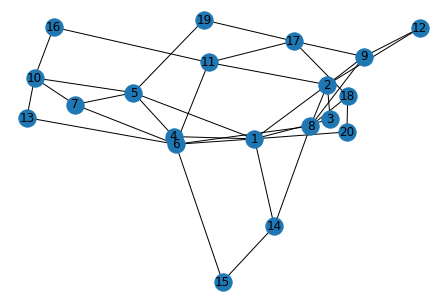

In [68]:
nx.draw_spectral(Bari_graph, with_labels=True) 

## Reports

In [ ]:
'''We have 
Ernyi(N=nodes, L=links) for random graph
Watatz(N=nodes, k=starting neighbours, p=P(relinking each edge))
Barabasi(m0=starting nodes/edges, m=added edges each time, t=times we add)
'''

### Random

In [29]:
'''Function that returns mean, variance of degree number, plots frequency of degrees and fits Poisson distribution
'''
def check_info(G):
    print('Number of nodes:', len(G.nodes), ' and number of edges:', len(G.edges))
    
    degrees = []
    for node in G.nodes:
        degrees.append(sum(node in edge for edge in G.edges))
    g_mean = np.mean(degrees)
    g_var = sum([(i-g_mean)**2 for i in degrees])/(len(degrees)-1)
    print('Mean degree:', g_mean, 'and variance:', g_var)
    
    min_d = min(degrees)
    max_d = max(degrees)
    x_stem = []
    y_stem = []
    for step in range(min_d, max_d+1):
        x_stem.append(step)
        y_stem.append(sum([deg==step for deg in degrees]))
    
    fig, ax = plt.subplots()
    ax.stem(x_stem, y_stem)
    ax.set_title('Frequency plot')
    
    #distribution
    z_stem=[]
    for i in y_stem:
        z_stem.append(i/len(G.nodes))
    ran = range(min_d, max_d+1)
    vals = [poisson.pmf(i, g_mean) for i in ran]
    fig, ax2 = plt.subplots()
    ax2.stem(x_stem, z_stem)
    ax2.plot(ran, vals, color='green', label='Poisson dist')
    ax2.set_title('Model - Poisson dist mith mean')
    ax2.legend()
    

In [185]:
random_graph = Ernyi(20, 40)

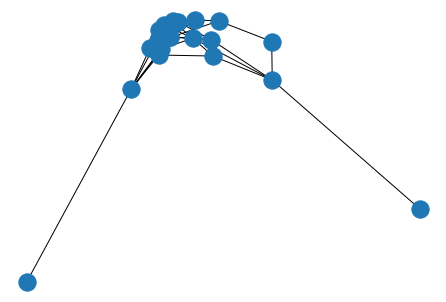

In [197]:
nx.draw_spectral(random_graph)

Number of nodes: 20  and number of edges: 40
Mean degree: 4.0 and variance: 3.1578947368421053


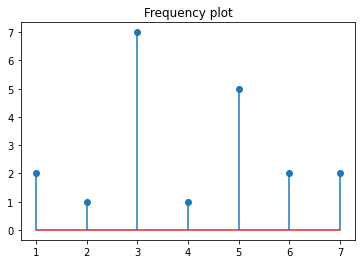

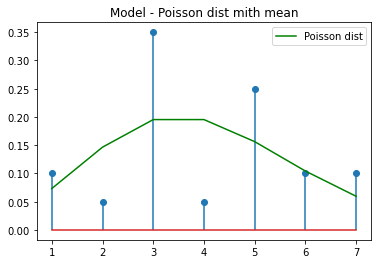

In [186]:
check_info(random_graph)

In [191]:
watatz_graph = Watatz(20, 6, 0.4)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


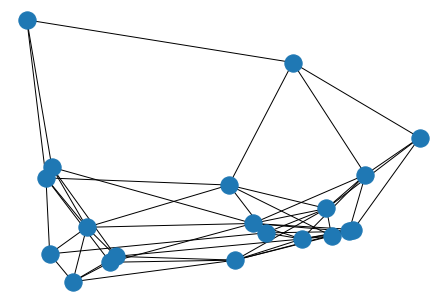

In [194]:
nx.draw_spectral(watatz_graph)

Number of nodes: 20  and number of edges: 40
Mean degree: 5.8 and variance: 2.063157894736842


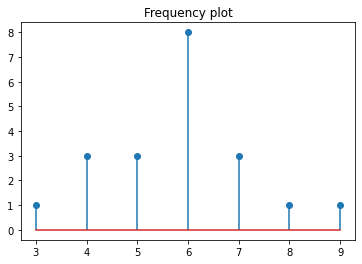

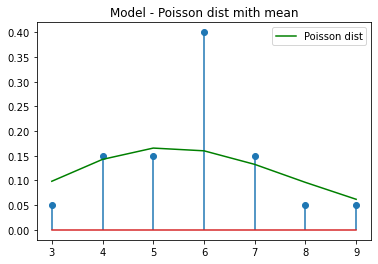

In [192]:
check_info(watatz_graph)

In [30]:
barabasi_graph = Barabasi(3, 3, 17)

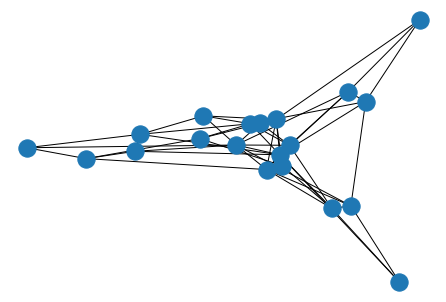

In [31]:
nx.draw_spectral(barabasi_graph)

Number of nodes: 20  and number of edges: 54
Mean degree: 5.4 and variance: 5.5157894736842135


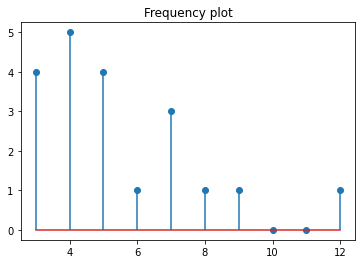

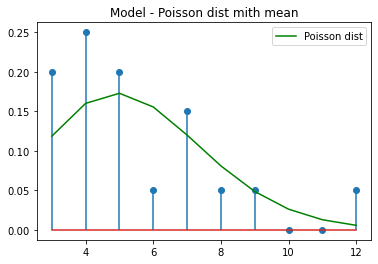

In [32]:
check_info(barabasi_graph)

Creators for graphs are working, examples are of number of nodes N=20, to easily check them visually. Chosen distribution is Poisson distribution with parametere equal to mean number of degrees. It best fits to Barabasi model. Maybe for Watts-Strogatz model better would something more normal, as we start with the same degree number and then it starts to change.

# Task 2

To scrap data from Twitter I used Snscrape library, which I learnt from article: 'Web Scraping with Python – How to Scrape Data from Twitter using Tweepy and Snscrape, under the link: https://www.freecodecamp.org/news/python-web-scraping-tutorial/

## Gathering mentions from Twitter

In [217]:
'''Function that returns last people mentioned by user along with list of edges created with them'''
def twit_mentions(user:str, number_of_mentions = 10):
    tweets_container = [] #here we keep tweets along with user that tweeted them if we want to check
    list_of_edges = [] #creating edges
    list_of_mentioned = [] #list of mentioned to work on them later
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+user).get_items()):
        if(i>number_of_mentions): #often there are more than 1 mention in each tweet, so this is a move to avoid looping in case we cant find more ppl
            break
        tweets_container.append([tweet.content, tweet.user])
        #now we want to fint words that begin with '@'
        words = tweet.content.split()
        for word in words:
            if(re.search("@\w", word)):
                if not([user, word[1:]] in list_of_edges): #if we are not already connected with him
                    list_of_edges.append([user, word[1:]]) #just nickname, without '@'
                    list_of_mentioned.append(word[1:])
                    if(len(list_of_mentioned)>=number_of_mentions): 
                        break #these step to only take 100 mentions, as we can mentions many ppl in 1 tweet
    
    return list_of_edges, list_of_mentioned

In [218]:
'''Starting from user, we gather some number of his mentions, we try to go to depth 2'''
def great_function(user, number_of_mentions=10, depth=6, network_G=nx.Graph()):
        
        #and now we do the things
        edges, mentions = twit_mentions(user, number_of_mentions) #edges do network, mentions do dalszej pracy
        #list_of_edges.extend(edges)
        network_G.add_edges_from(edges)
        
        #bruteforcing as we have small depth level
        for one_mention in mentions: 
            e2, m2 = twit_mentions(one_mention, number_of_mentions)
            network_G.add_edges_from(e2)
            for one_mention2 in m2:
                e3, m3 = twit_mentions(one_mention2, number_of_mentions)
                network_G.add_edges_from(e3)
                for one_mention3 in m3:
                    e4, m4 = twit_mentions(one_mention3, number_of_mentions)
                    network_G.add_edges_from(e4)
                    #for one_mention4 in m4:
                        #e5, m5 = twit_mentions(one_mention4, number_of_mentions)
                        #network_G.add_edges_from(e5)
    
        return network_G

In [11]:
def check_twitter(G):
    print('Number of nodes:', len(G.nodes), ' and number of edges:', len(G.edges))
    
    degrees = []
    for node in G.nodes:
        degrees.append(sum(node in edge for edge in G.edges))
    
    min_d = min(degrees)
    max_d = max(degrees)
    x_stem = []
    y_stem = []
    for step in range(min_d, max_d+1):
        x_stem.append(step)
        y_stem.append(sum([deg==step for deg in degrees]))
    
    fig, ax = plt.subplots()
    ax.stem(x_stem, y_stem)
    ax.set_title('Frequency plot')
    ax.grid()
    

#### Now I have two networks, one is size 70k of edges and another 1.7k, other being easier to look at.

## Smaller sample

In [234]:
#gather data
start = time.time()
last_try = great_function('TomaszSzymcza15', number_of_mentions=10);
print(time.time()-start)

<ipython-input-217-1bbf13e5d173>:9: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_container.append([tweet.content, tweet.user])
<ipython-input-217-1bbf13e5d173>:11: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  words = tweet.content.split()
Stopping after 20 empty pages


284.673148393631


In [ ]:
#(a) here we save it into file
with open('Last_try.pickle', 'wb') as f:
    pickle.dump(last_try, f)

In [2]:
#(a) here we upload from file
with open('Last_try.pickle', 'rb') as f:
    again = pickle.load(f)

In [4]:
# save it into csv to easily open Gephi
# '&' is a separator as it does not appear in nickanems
with open('Last_try.csv', 'w', encoding="utf-8") as csvFile: #, encoding="utf-8"
    csvFile.write('Source&Target&Type\n')
    for i in again.edges:
        try:
            csvFile.write(i[0]+'&'+ i[1]+'&'+'Directed'+'\n')
        except:
            pass #sometimes an error can occure

Number of nodes: 1661  and number of edges: 1857


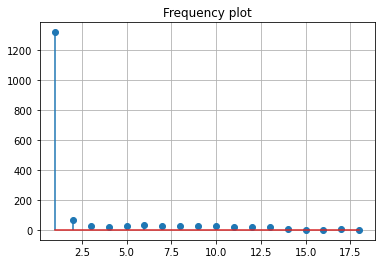

In [12]:
#(b), (e)
check_twitter(again)

Looking at picture above, I'm not sure if friend paradox would work, as most of nodes have degree of 1

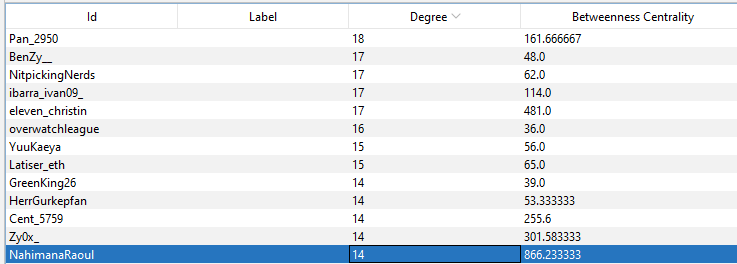

In [27]:
#(c)
Image("Celebrities_small.png")

There is list of 13 users with biggest number of degrees, selected one has the biggest Betweeness Centrality

In [25]:
#(d)
size = 1000
mean_path = 0
for i in range(size):
    [a,b] = random.sample(again.nodes, 2)
    mean_path+=nx.shortest_path_length(again, a, b)
print('Mean length of shortest path is',mean_path/size)

Mean length of shortest path is 6.936


Instead of checking friend paradox I've checked 'Six degrees of separation' concept. It is close to 6

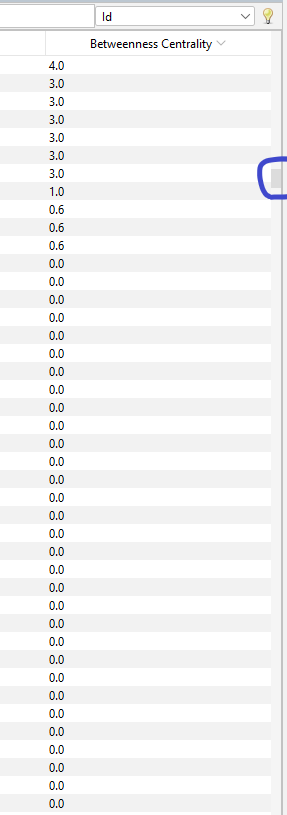

In [13]:
#(f)
#as before, most of nodes (~80%) have betweeness centrality equal to zero, creating bottlenecks
Image("Betweeness_2.png")

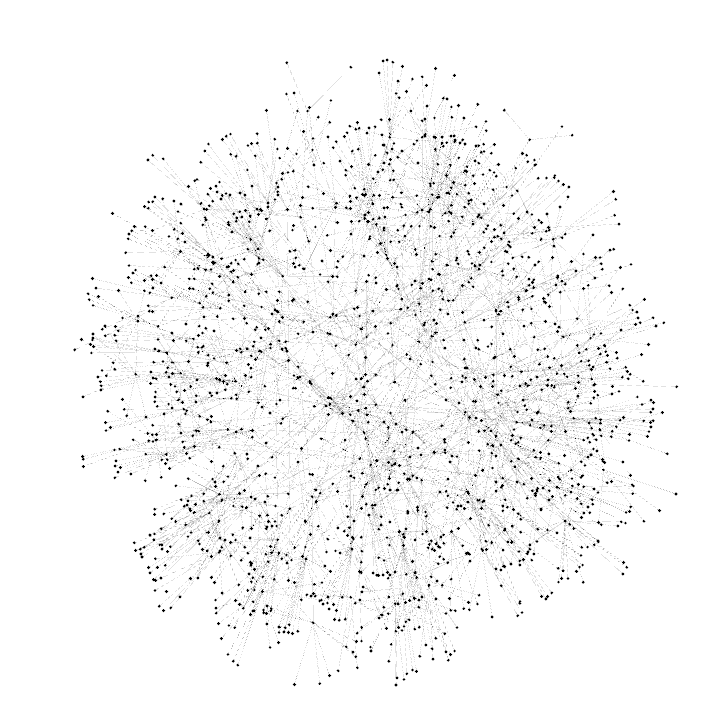

In [10]:
#(g)
Image("Twitter_smaller.png")

## Big network

In [200]:
start = time.time()
G2 = great_function('TomaszSzymcza15', number_of_mentions=3, depth=5);
print(time.time()-start)
#with open('Twitter_mentions_2.pickle', 'wb') as f:
#    pickle.dump(G2.edges, f)

<ipython-input-198-1bbf13e5d173>:9: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_container.append([tweet.content, tweet.user])
<ipython-input-198-1bbf13e5d173>:11: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  words = tweet.content.split()


10.95796513557434


In [19]:
with open('Twitter_mentions_2.pickle', 'rb') as f:
     short_data = pickle.load(f)

In [201]:
'''There is a quick code to convert pickle into csv to open network in gephi
    separator will be '&', as in cotrary to ',' or '*' it does not appear as a part of nickames.
    I choose utf-8, as some people use weird symbols in ther names, also something can get lost when saving into csv.
'''
#with open('Edges.csv', 'w', encoding="utf-8") as csvFile: #, encoding="utf-8"
#    csvFile.write('Source&Target&Type\n')
#    for i in new_data:
#        try:
#            csvFile.write(i[0]+'&'+ i[1]+'&'+'Directed'+'\n')
#        except:
#            pass #

"There is a quick code to convert pickle into csv to open network in gephi\n    separator will be '&', as in cotrary to ',' or '*' it does not appear as a part of nickames.\n    I choose utf-8, as some people use weird symbols in ther names, also something can get lost when saving into csv.\n"

In [20]:
new_G = nx.Graph()
new_G.add_edges_from(short_data)

(b) number of nodes and edges

In [210]:
print('Amount of nodes:',len(new_G.nodes))
print('Amount of edges:',len(new_G.edges))

Amount of nodes: 57552
Amount of edges: 77658


(d), Instead of checking friend paradox I've checked 'Six degrees of separation' concept.
In this case we will treat network as undirected

In [23]:
mean_path = 0
size = 10000
for i in range(size):
    [a,b] = random.sample(new_G.nodes, 2)
    mean_path+=nx.shortest_path_length(new_G, a, b)
print('Mean length of shortest path is',mean_path/size)

Mean length of shortest path is 6.185


(f): as we dive into gephi, it looks like most of this network has betweeness centrality equal to 0, so it is quite bottlenecked

(g) image taken from Gephi

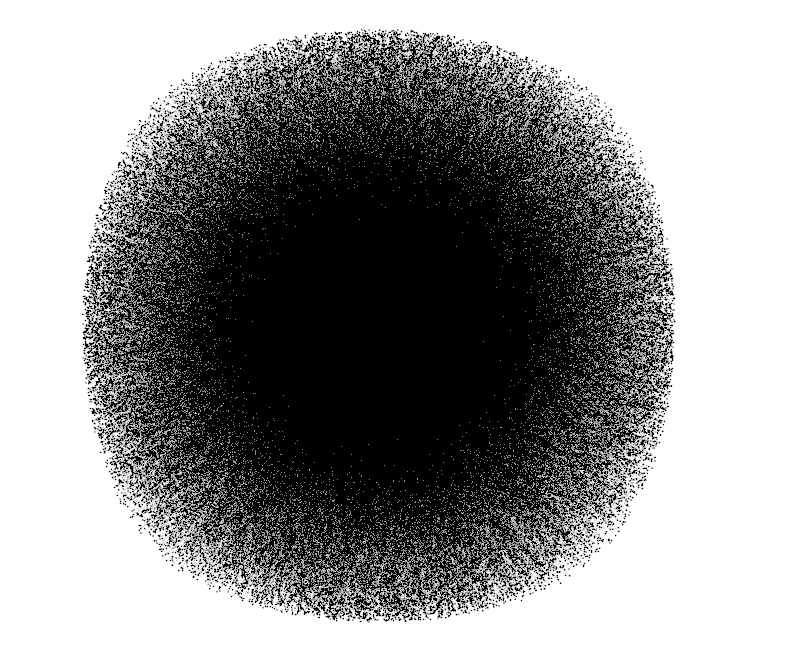

In [233]:
Image("Twitter_image.png")